# **07MIAR - Redes Neuronales y Deep Learning: Proyecto de programación**

## **Estrategia 2: Red pre-entrenada**

### **1. Carga y acondicionamiento del conjunto de datos**




Dataset: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset

#### **1.1. Descarga del dataset desde la plataforma kaggle**

In [1]:
#Cargamos el fichero de autenticación de kaggle
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
#Descargamos el dataset
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

 97% 516M/534M [00:03<00:00, 201MB/s]
100% 534M/534M [00:03<00:00, 160MB/s]


In [3]:
#Descomprimimos el dataset
!unzip -q vegetable-image-dataset.zip

#### **1.2. Carga del dataset y acondicionamiento de datos**
1. Utilizamos el generador para mayor eficiencia en la carga de datos.
2. Utilizamos el parametro class_mode='categorical' para realizar One-hot encoding.
3. Con el parámetro rescale=1./255 normalizamos para disminuir el coste computacional.
4. En el generador de datos de train utilizamos **data augmentation** con el que modificamos las imágenes de entrada al entrenamiento con el fin de aumentar la capacidad de generalización del modelo. En el caso del modelo **from scratch** se aplican rotaciones, variaciones en los canales de la imageny desplazamientos verticales y horizontales.


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir los directorios de los conjuntos de datos
train_dir = 'Vegetable Images/train'
test_dir = 'Vegetable Images/test'
val_dir = 'Vegetable Images/validation'

# Definir el tamaño de imagen que se utilizará para el modelo
img_size = (128, 128)

# Definir el generador de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rotation_range=15,
    channel_shift_range=0.1,
    width_shift_range=0.1, # Desplazamiento horizontal aleatorio
    height_shift_range=0.1, # Desplazamiento vertical aleatorio
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=64,
        class_mode='categorical')

# Definir el generador de datos para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=64,
        shuffle = False,
        class_mode='categorical')

# Definir el generador de datos para el conjunto de validación
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=64,
        class_mode='categorical')

# Obtener los datos y las etiquetas de los generadores de datos
x_train, y_train = train_generator.next()
x_test, y_test = test_generator.next()
x_val, y_val = val_generator.next()


Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


### **2. Inspección del conjunto de datos**

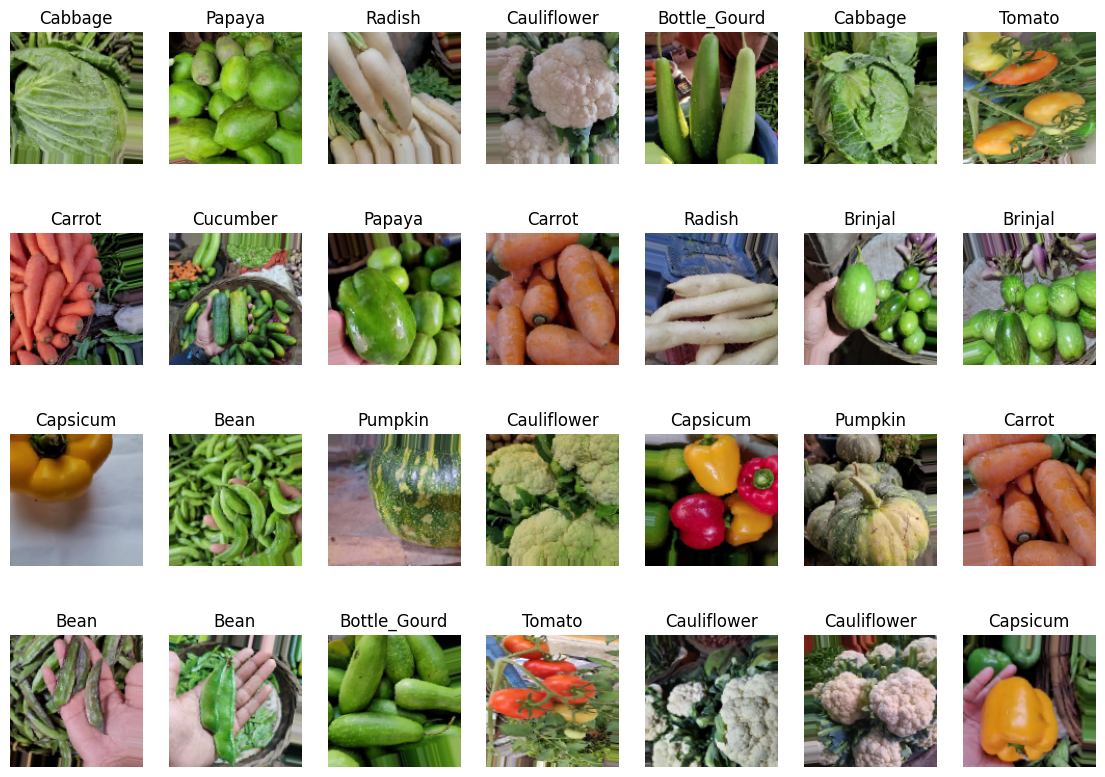

In [5]:
import matplotlib.pyplot as plt

# Obtener la lista de nombres de las clases
class_names = list(train_generator.class_indices.keys())

fig = plt.figure(figsize=(14,10))
for n in range(1, 29):
    fig.add_subplot(4, 7, n)
    img = x_train[n]
    plt.imshow(img)
    plt.axis('off')
    # Agregar el título de la clase correspondiente
    label_index = y_train[n].argmax()
    plt.title(class_names[label_index])
plt.show()


### **3. Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución**

#### **3.1. Búsqueda de hiperparámetros**


##### **3.1.1. Instalación de keras-tuner**


In [6]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.3 MB/s eta 0:00:00


##### **3.1.2. Definición de model builder**


*   weight_regularization = [1e-1,1e-2, 1e-3]
*   dropout = [0.0, 0.1, 0.25]
*   hp_learning_rate = [1e-1, 1e-2, 1e-3]
*   optimizer = [Adam, SGD]






In [19]:
import tensorflow as tf
import IPython
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping



class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

def model_builder(hp):
    #########################################
    ###### Definimos la arquitectura ########
    #########################################
    # Definir el factor de regularización de peso
    hp_weight = hp.Choice('weight_regularization', values = [1e-1,1e-2, 1e-3]) 
    # Definir la tasa de dropout
    hp_dropout = hp.Choice('dropout', values = [0.0, 0.1, 0.25])
    # Definir la tasa de aprendizaje
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3]) 
    # Definir el optimizador
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
   # Crear el modelo
    model = Sequential()

    # Añadir capas convolucionales y de pooling
    model.add(layers.Conv2D(32, (3, 3), strides=1, padding='same', input_shape=(img_size[0], img_size[1], 3), kernel_regularizer=l2(hp_weight)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(2))

    model.add(layers.Conv2D(64, (3, 3), strides=1, padding='same', kernel_regularizer=l2(hp_weight)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(2))

    #Flatten the feature map
    model.add(layers.Flatten())

    #TOP MODEL
    model.add(layers.Dense(128,activation='relu', kernel_regularizer=l2(hp_weight)))
    model.add(layers.Dropout(hp_dropout))
    model.add(layers.Dense(128,activation='relu', kernel_regularizer=l2(hp_weight)))
    model.add(layers.Dropout(hp_dropout))
    model.add(layers.Dense(15,activation='softmax'))

    # Compilar el modelo
    if optimizer == 'adam':
        model.compile(optimizer=optimizers.Adam(hp_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer=optimizers.SGD(hp_learning_rate), loss='categorical_crossentropy', metrics=['accuracy']) 
        
    return model


##### **3.1.3. Definimos el tuner a utilizar**



*   Utilizamos el Hyperband.
*   El objetivo es optimizar el valor de acierto.
*   Máximo de épocas 20



In [20]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 20,
                     seed = 42)  

##### **3.1.4. Ejecutamos el tunner**


In [ ]:
tuner.search(train_generator, validation_data = val_generator, steps_per_epoch = int(train_generator.samples / 64), epochs=20)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. The optimal dropout is {best_hps.get('dropout')}. The 
optimal weight regularization is {best_hps.get('weight_regularization')} . The best optimizer is {best_hps.get('optimizer')}
""")

#### **3.2. Arquitectura adoptada**


##### **3.2.1. Hiperparámetros**


*   Los hiperparámetros han sido escogidos en base a los resultados recibidos tras ejecutar el tuner.


*   hp_weight = 0.001 -> peso utilizado para regulación l2 con el fin de reducir el overfitting.
*   hp_dropout = 0.1 -> tasa de dropout (apagado azaroso de conexiones neuronales) con el fin de reducir el overfitting.
*   learning_rate = 0.1 -> tasa de aprendizaje utilizada en el algoritmo optimizador.
*   optimizer = SGD -> algoritmo de optimización utilizado.

##### **3.2.2. Capas**

1.   Primera capa: 32 filtros tamaño 3x3, activación ReLU y max pooling
2.   Segunda capa: 64 filtros tamaño 3x3, activación ReLU y max pooling
3.   Se aplana el texto utilizando Flatten
4.   Top model para la clasificación de imágenes: 
    - 2 Capas densas de 128 entradas, activación por ReLU y dropout
    - Capa densa de 15 entradas, activación por softmax

##### **3.2.3. Otras arquitecturas**

Se han probado otras arquitecturas variando la complejidad de éstas, ya sea añadiendo más capas y otras técnicas para reducir el overfitting como **batch normalization** en las capas convolucionales, pero esta ha sido la adoptada finalmente debido a que ha sido la que nos ha retornado una mayor de tasa de acierto a la hora de probar el modelo con los datos de test.

##### **3.2.4. Código de la arquitectura**



In [21]:
import tensorflow as tf

# Definir el factor de regularización de peso
hp_weight = 0.001
# Definir la tasa de dropout
hp_dropout = 0.1
# Definir la tasa de aprendizaje
hp_learning_rate = 0.1

# Crear el modelo
model = Sequential()

# Añadir capas convolucionales y de pooling
model.add(layers.Conv2D(32, (3, 3), strides=1, padding='same', input_shape=(img_size[0], img_size[1], 3), kernel_regularizer=l2(hp_weight)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(64, (3, 3), strides=1, padding='same', kernel_regularizer=l2(hp_weight)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(2))

#Flatten the feature map
model.add(layers.Flatten())

#TOP MODEL
model.add(layers.Dense(128,activation='relu', kernel_regularizer=l2(hp_weight)))
model.add(layers.Dropout(hp_dropout))
model.add(layers.Dense(128,activation='relu', kernel_regularizer=l2(hp_weight)))
model.add(layers.Dropout(hp_dropout))
model.add(layers.Dense(15,activation='softmax'))

# Definir el optimizador con la tasa de aprendizaje
optimizer = optimizers.SGD(hp_learning_rate)

# Compilar el modelo
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 activation_8 (Activation)   (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 activation_9 (Activation)   (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                  

#### **3.3. Entrenamiento**



*   Definimos **earlystopping** con una paciencia de 3 épocas con el fin de evitar el sobreajuste y mejorar la eficiencia del entrenamiento.
*   Definimos los pasos por época con un tamaño de **batch** de 64.
* Definimos 100 épocas. Tamaño suficientemente amplio para que entre en acción el early stopping.




In [22]:
early_stopping = EarlyStopping(patience=3)
# Entrenar el modelo
history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    steps_per_epoch=int(train_generator.samples/64), 
    epochs=100,
    callbacks=early_stopping)

# Evaluar el modelo con los datos de prueba
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

Epoch 1/100
234/234 [==============================] - 109s 458ms/step - loss: 2.9157 - accuracy: 0.1620 - val_loss: 2.5246 - val_accuracy: 0.2500
Epoch 2/100
234/234 [==============================] - 107s 457ms/step - loss: 2.5136 - accuracy: 0.2893 - val_loss: 2.0342 - val_accuracy: 0.4487
Epoch 3/100
234/234 [==============================] - 110s 469ms/step - loss: 2.0316 - accuracy: 0.4426 - val_loss: 1.7055 - val_accuracy: 0.5390
Epoch 4/100
234/234 [==============================] - 108s 459ms/step - loss: 1.7159 - accuracy: 0.5612 - val_loss: 1.3105 - val_accuracy: 0.7127
Epoch 5/100
234/234 [==============================] - 106s 454ms/step - loss: 1.3961 - accuracy: 0.6693 - val_loss: 1.0817 - val_accuracy: 0.7707
Epoch 6/100
234/234 [==============================] - 107s 456ms/step - loss: 1.2163 - accuracy: 0.7294 - val_loss: 2.0840 - val_accuracy: 0.5557
Epoch 7/100
234/234 [==============================] - 107s 457ms/step - loss: 1.0886 - accuracy: 0.7758 - val_loss: 0

### **4. Monitorización del proceso de entrenamiento para la toma de decisiones**





*   Implementamos la función para pintar la gráfica del entrenamiento del modelo.
*   Mostramos las funciones de: pérdida de entrenamiento/validación y aciertos de entrenamiento/validación.

In [23]:
import matplotlib.pyplot as plt
import numpy as np
def pintarGrafica(epocas, modelo):
  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, epocas), modelo.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epocas), modelo.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epocas), modelo.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epocas), modelo .history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

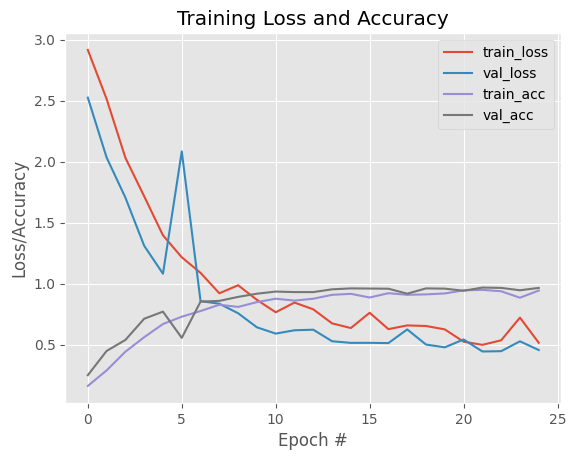

In [24]:
pintarGrafica(25, history)

### **5. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental**



#### **5.1. Evaluación de modelo por cada clase**

In [25]:
from sklearn.metrics import classification_report

# Obtener las etiquetas verdaderas del conjunto de test
y_true = test_generator.classes

# Obtener las etiquetas predichas del conjunto de test
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Generar el informe de clasificación
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))


47/47 [==============================] - 6s 121ms/step
              precision    recall  f1-score   support

        Bean       0.88      1.00      0.94       200
Bitter_Gourd       0.97      0.94      0.95       200
Bottle_Gourd       0.98      0.99      0.98       200
     Brinjal       0.97      0.96      0.97       200
    Broccoli       0.99      0.96      0.98       200
     Cabbage       0.97      0.93      0.95       200
    Capsicum       0.98      0.99      0.99       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       0.94      0.96      0.95       200
    Cucumber       0.99      0.95      0.97       200
      Papaya       0.97      0.98      0.98       200
      Potato       0.97      1.00      0.99       200
     Pumpkin       0.98      0.90      0.93       200
      Radish       0.99      0.98      0.99       200
      Tomato       0.93      0.95      0.94       200

    accuracy                           0.97      3000
   macro avg       0.97  

#### **5.2. Evaluación total del modelo**

In [26]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

47/47 [==============================] - 6s 121ms/step - loss: 0.4605 - accuracy: 0.9667
Test loss: 0.4604552686214447
Test accuracy: 0.9666666388511658
